# Compare NAEI & EDGAR

Calculate APO using NAEI & EDGAR to compare the models

In [1]:
import os
import glob
import xarray as xr
from datetime import datetime
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta

from acrg.name import name
from acrg.obs import get_obs
from acrg.convert import concentration

import apo_emiss_func, apo_plot_info, apo_funcs

In [2]:
year = 2015
months = [8, 12]

sites = ['WAO']

sigma = 3

save = False

starts = {month: datetime(year, month, 1) for month in months}
end = {month: start + relativedelta(months=1, seconds=-1) for month, start in starts.items()}

date_str = f'{year}' if months==[mm for mm in range(1, 13)] else \
           f'{year}{str(months[0]).zfill(2)}-{str(months[-1]).zfill(2)}' if len(months)>2 else \
           f'{year}{str(months[0]).zfill(2)}-{year}{str(months[-1]).zfill(2)}' if len(months)==2 else None

print(date_str)

201508-201512


## Show the emissions fields

In [3]:
emissions = {inv: {month: name.flux(domain = 'EUROPE',
                                    species = f'co2-{inv}-ff-1hr',
                                    start = start,
                                    end = end[month],
                                    chunks = {'time': 50})
                   for month, start in starts.items()}
             for inv in ['edgar-ukghg', 'edgar']}


Searching for flux files: /group/chemistry/acrg/LPDM/emissions/EUROPE/co2-edgar-ukghg-ff-1hr_*.nc
Reading and concatenating files: 
/group/chemistry/acrg/LPDM/emissions/EUROPE/co2-edgar-ukghg-ff-1hr_EUROPE_2015.nc


### Compare the fields

Take the average of each field and find the difference between them

In [ ]:
field_averages = {month: {inv: em_inv[month].flux.values.mean()
                          for inv, em_inv in emissions.items()}
                  for month in months}

In [22]:
diff_per_cent = {month: (field_average['edgar'] - field_average['edgar-ukghg']) / field_average['edgar-ukghg'] * 100
                 for month, field_average in field_averages.items()}

{8: 0.773531710729003, 12: 0.7252439390867949}

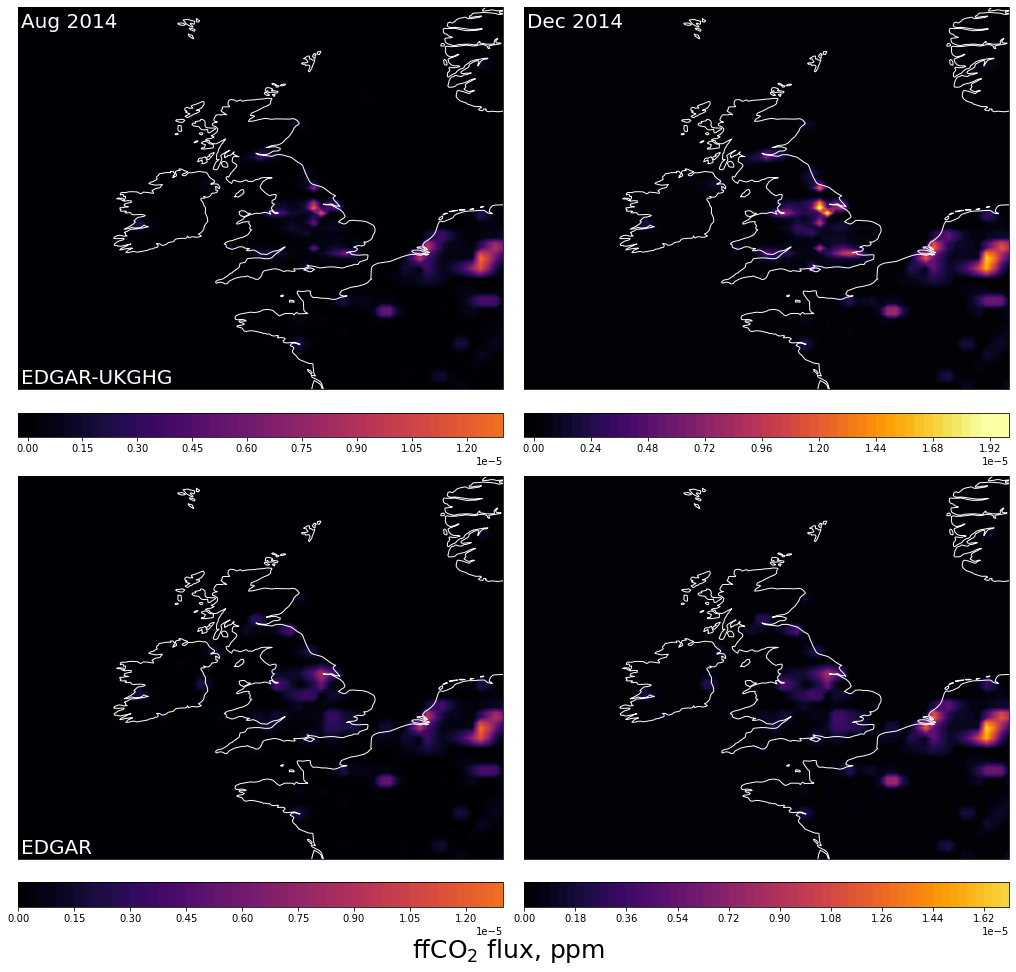

In [ ]:
fields_data = {inv: {month: em_month.flux[:,:,0] for month, em_month in em_inv.items()}
               for inv, em_inv in emissions.items()}
fields_data = apo_funcs.flatten_nested_dict(fields_data)
labels = [inv.split('_')[0].upper() for inv in fields_data.keys()]

fig, axes = apo_funcs.show_map(data = list(fields_data.values()),
                               fig_kwargs = {'nrows':2, 'ncols':2, 'constrained_layout': True,
                                             'figsize': (14, 13)},
                               im_kwargs = {'vmin': 0, 'vmax': 1.9e-5, },
                               crop_uk = True,
                               coast_color = 'white',
                               show = False)
cbar_label = fig.text(0.5, -0.0, r'ffCO$_2$ flux, ppm', va='top', ha='center', fontsize=25)
text = [axes[0][mm].text(0.005, 0.985, f'{apo_plot_info.month_names[month]} {year}', transform=axes[0][mm].transAxes,
                         va='top', fontsize=20, color='white')
        for mm, month in enumerate(months)]
text = [axes[ii][0].text(0.005, 0.005, f'{inv.upper()}', transform=axes[ii][0].transAxes,
                         va='bottom', fontsize=20, color='white')
        for ii, inv in enumerate(emissions.keys())]
plt.show()

### Compare the emissions fields

Get the difference in the emissions fields

Saving figure as /user/work/vf20487/Figures/FluxFields/CO2_EDGAR_UKGHG-EDGAR_comparison_201408-201412.png


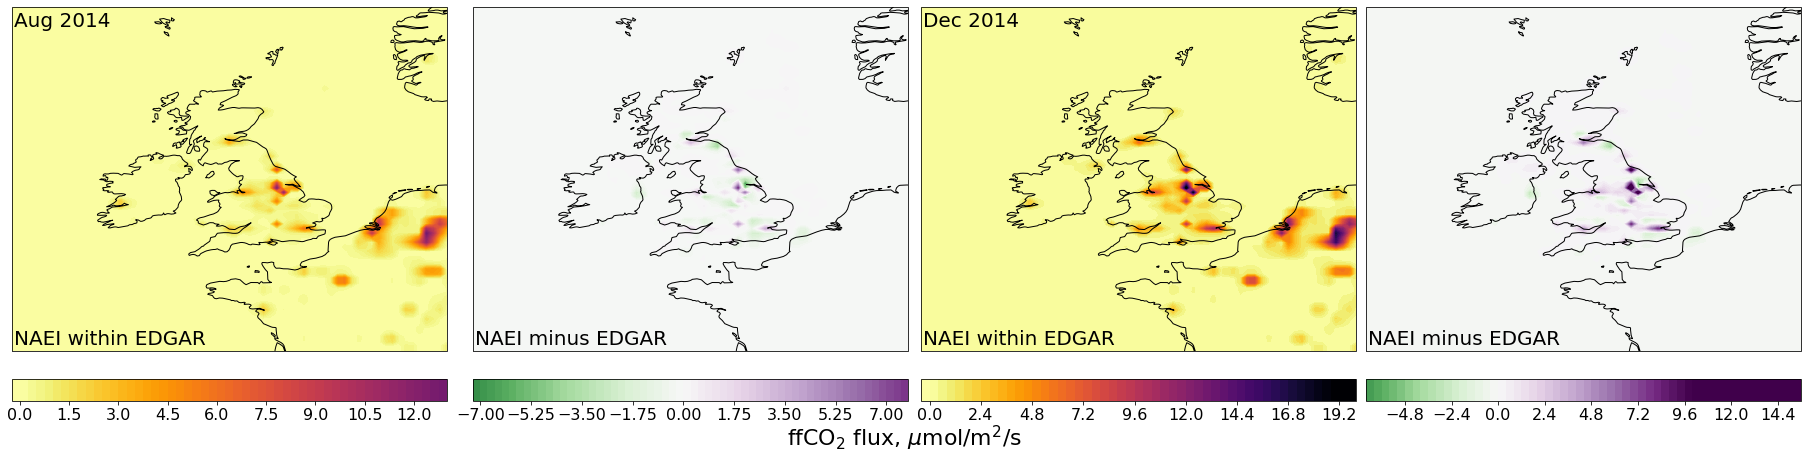

In [6]:
fields_diff = {month: (emissions['edgar-ukghg'][month].flux - emissions['edgar'][month].flux)[:,:,0]
               for month in months}

fields_diff_perc = {month: abs(diff / emissions['edgar-ukghg'][month].flux[:,:,0] * 100)
                    for month, diff in fields_diff.items()}
fields_diff_perc = {month: diff.where(diff<100) for month, diff in fields_diff_perc.items()}

fields_diff_data = list(fields_data.values())[:2] + list(fields_diff.values())
fields_diff_data = [fields_diff_data[0], fields_diff_data[2], fields_diff_data[1], fields_diff_data[3]]
fields_diff_data = [ff * 1e6 for ff in fields_diff_data]

# orig_map=plt.cm.get_cmap('inferno')
# reversed_map = orig_map.reversed()
fig, axes = apo_funcs.show_map(data = fields_diff_data,
                               fig_kwargs = {'constrained_layout': True, 'figsize': (25, 8)},
                               im_kwargs = [{'cmap': 'inferno', 'vmin':-0, 'vmax':19}, {'cmap': 'PRGn', 'vmin': -10, 'vmax':10},
                                            {'cmap': 'inferno', 'vmin': 0, 'vmax':19}, {'cmap': 'PRGn', 'vmin': -10, 'vmax':10}],
                               colorbar_tick_kwargs={'labelsize': 16},
                               crop_uk = True,
                               coast_color = 'black',
                               show = False,
                               reverse_cmap = True)

cbar_label = fig.text(0.5, -0.0, r'ffCO$_2$ flux, $\mu$mol/m$^2$/s', va='top', ha='center', fontsize=22)
text = [axes[mm*2].text(0.005, 0.985, f'{apo_plot_info.month_names[month]} {year}', transform=axes[mm*2].transAxes,
                         va='top', fontsize=20, color='black')
        for mm, month in enumerate(months)]
text = [axes[ll].text(0.005, 0.005, f'{label}', transform=axes[ll].transAxes,
                         va='bottom', fontsize=20, color='black')
        for ll, label in enumerate(['NAEI within EDGAR', 'NAEI minus EDGAR']*2)]

file_name = os.path.join('/user', 'work', 'vf20487', 'Figures', 'FluxFields', f'CO2_EDGAR_UKGHG-EDGAR_comparison_{date_str}.png')
print(f'Saving figure as {file_name}')
fig.savefig(file_name, bbox_inches='tight', pad_inches=0.2)

# fig, axes = apo_funcs.show_map(data = list(fields_diff_perc.values()),
#                                fig_kwargs = {'constrained_layout': True, 'figsize': (13, 6)},
#                                im_kwargs = {},
#                                crop_uk = True,
#                                coast_color = 'white',
#                                show = False)
# cbar_label = fig.text(0.5, -0.0, r'ffCO$_2$ flux, per cent', va='top', ha='center', fontsize=22)
# text = [axes[mm].text(0.005, 0.985, f'{apo_plot_info.month_names[month]} {year}', transform=axes[mm].transAxes,
#                          va='top', fontsize=20, color='white')
#         for mm, month in enumerate(months)]
# plt.show()

## Get the timeseries

We import the pre-run forward models here

In [3]:
inv_idents = {'ukghg': '', 'edgar': '_edgar-gridfed', 'ukghg-gridfed': '_gridfed'}

sources = [f'ff{inv_ident}' for inv_ident in inv_idents.values()]
[sources.append(source) for source in ['ocean', 'bc']]
ts_data_all = apo_funcs.get_timeseries(sites = sites,
                                       sources = sources,
                                       year = year)
ts_data_all = {site: {month: ts_site.sel(time=slice(start, end[month]))
                      for month, start in starts.items()}
               for site, ts_site in ts_data_all.items()}

Finding timeseries for WAO
ff: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ff_timeseries_2015.nc']
ff_edgar-gridfed: []
ff_gridfed: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ff_gridfed_timeseries_2015.nc']
ocean: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ocean_timeseries_2015.nc']
bc: ['/user/work/vf20487/Timeseries/o2_co2/WAO_bc_timeseries_2015.nc']

Data variables:
['co2_ff', 'o2_ff', 'co2_ff_gridfed', 'o2_ff_gridfed', 'o2_ocean_nemo', 'n2_ocean_nemo', 'o2_ocean_ecco', 'o2_ocean_jena', 'co2_ocean_nemo', 'apo_bc', 'co2_bc', 'o2_bc']


### Plot O2 and CO2

We plot the O2 and CO2 timeseries from both inventories to compare

Get the pre-run forward model for all APO components

We will use this to model APO using both ffCO2 inventories to compare

In [4]:
correlations = {month: {species: xr.corr(ts_month[f'{species}_ff'], ts_month[f'{species}_ff_edgar_gridfed'])
                        for species in ['co2', 'o2']}
                for month, ts_month in ts_data_all['WAO'].items()}

print_correlations = [[print(f'{month}, {species}, ukghg-edgar correlation: {correlation.values}')
                      for species, correlation in corr_month.items()] for month, corr_month in correlations.items()]

lines = {'ukghg': {'ls': '-', 'color': 'magenta'},
         'edgar': {'ls': '--', 'color': 'forestgreen'}}
        #  'ukghg-gridfed': {'ls': ':', 'color': 'dodgerblue'}}
labels = {'ukghg': 'NAEI', 'edgar': 'EDGAR'}

fig, axes = plt.subplots(nrows=2*len(months), ncols=1, figsize=(25, 7*len(months)), constrained_layout=True)

for mm, (month, ts_month) in enumerate(ts_data_all['WAO'].items()):
    for ss, spec in enumerate(['co2', 'o2']):
        plots = [ts_data_all['WAO'][month][f'{spec}_ff{inv_idents[inv]}'.replace('-', '_')].plot(ax=axes[ss+2*mm], label=labels[inv], ls=lines[inv]['ls'], color=lines[inv]['color'])
                 for inv, inv_ident in inv_idents.items() if inv in lines.keys()]

[axes[ii].xaxis.set_ticklabels([]) for ii in [i for i in range(0, len(axes))[0%2::2]]]
sites_text = [r'CO$_2$', r'O$_2$']*2
[ax.text(0.01, 0.05, sites_text[aa], va='bottom', transform=ax.transAxes, fontsize=25) for aa, ax in enumerate(axes)]

if len(months)>1:
       myFmt = mdates.DateFormatter('%d')
       [ax.xaxis.set_major_formatter(myFmt) for ax in axes]
       ticks = [ax.tick_params(labelsize=20, labelrotation=0) for ax in axes]
       text = [axes[mm*2].text(0.005, 0.985, f'{apo_plot_info.month_names[month]} {year}', transform=axes[mm*2].transAxes, va='top', fontsize=20)
               for mm, month in enumerate(months)]
else:
       ticks = [ax.tick_params(labelsize=20) for ax in axes]

# ylabel = [axes[ss].set_ylabel(f'mol fraction contribution, ppm', fontsize=20) for ss, spec in enumerate(['CO2', 'O2'])]
grid = [ax.grid() for ax in axes]
ylabel = [ax.set_ylabel('') for ax in axes]
ylabel = fig.text(-0.01, 0.5, 'regional ff contribution, ppm', va='center', ha='center', rotation='vertical', fontsize=25)
xlabel = [ax.set_xlabel('') for ax in axes]
legend = axes[0].legend(loc='best', fontsize=20)
tick_param = [ax.tick_params(axis='both', which='major', labelsize=20) for ax in axes]

date_str = '-'.join([f'{year}{str(month).zfill(2)}' for month in months])
filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'Timeseries',
                        f'ff_Timeseries_{date_str}.png')
if save:
    print(f'Saving to {filename}')
    fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

KeyError: 'co2_ff_edgar_gridfed'

### Model APO

In [4]:
apo_model = {site: {month: {sim: apo_emiss_func.apo(ocean_co2 = ts_month.co2_ocean_nemo,
                                                    ocean_n2 = ts_month.n2_ocean_nemo,
                                                    ocean_o2 = ts_month.o2_ocean_nemo,
                                                    ff_co2 = ts_month[f'co2_ff{sim_str.replace("-", "_")}'],
                                                    ff_o2 = ts_month[f'o2_ff{sim_str.replace("-", "_")}']) + ts_month.apo_bc - apo_plot_info.adjust[year][month]
                            for sim, sim_str in inv_idents.items()}
                    for month, ts_month in ts_site.items()}
             for site, ts_site in ts_data_all.items()}

### Import the APO observations

In [5]:
apo_obs = {month: get_obs(sites, 'APO', start_date, end[month], keep_missing=True)
           for month, start_date in starts.items()}

Assuming status flag = 0 for all sites
Getting APO data for WAO...
... reading /group/chemistry/acrg/obs/WAO/UEA-Oxzilla_WAO_20100519_APO-20211221.nc
... slicing from 2014-08-01 00:00:00 to 2014-08-31 23:59:58.999999999
Assuming status flag = 0 for all sites
Getting APO data for WAO...
... reading /group/chemistry/acrg/obs/WAO/UEA-Oxzilla_WAO_20100519_APO-20211221.nc
... slicing from 2014-12-01 00:00:00 to 2014-12-31 23:59:58.999999999


### Get the model uncertainty

We import the model uncertainty so that we can plot the ff uncertainty onto the same figure

In [6]:
path_unc = os.path.join('/user', 'work', 'vf20487', 'Sensitivities')
date_strs = {month: f'{year}{str(month).zfill(2)}' for month in months}
uncertainty_filenames = {month: glob.glob(os.path.join(path_unc, f'APO_unc*{date_str}.nc'))[0]
                         for month, date_str in date_strs.items()}
print(f'Uncertainty file: {uncertainty_filenames}')

data_unc = {month: name.open_ds(file_month) for month, file_month in uncertainty_filenames.items()}

ocean_o2_model = 'nemo'
# adjust the baseline of the APO model
for month, data_month in data_unc.items():
    data_unc[month][f'model_{ocean_o2_model}'] = data_month[f'model_{ocean_o2_model}'] - apo_plot_info.adjust[year][month]

Uncertainty file: {8: '/user/work/vf20487/Sensitivities/APO_uncertainties_201408.nc', 12: '/user/work/vf20487/Sensitivities/APO_uncertainties_201412.nc'}


In [7]:
apo_uncertainty_total = {}

for month, unc_month in data_unc.items():
        if 'ff_nemo' not in unc_month.data_vars:
                print(f'{apo_plot_info.month_names[month]}: Calculating APO uncertainty using error propagation')
                apo_uncertainty = {'co2': ((1.1 / 0.20946)**2 * (0.1*ts_data_all['WAO'][month].co2_ff)**2)**0.5,
                                   'o2': ((1.1 / 0.20946)**2 * (0.1*ts_data_all['WAO'][month].o2_ff)**2)**0.5}

                apo_uncertainty_total[month] = (apo_uncertainty['co2'][month]**2 + apo_uncertainty['o2'][month]**2)**0.5
        else:
                print(f'{apo_plot_info.month_names[month]}: Using APO uncertainty calculated using a Monte Carlo method')
                apo_uncertainty_total[month] = unc_month.ff_nemo

Aug: Using APO uncertainty calculated using a Monte Carlo method
Dec: Using APO uncertainty calculated using a Monte Carlo method


In [24]:
print_uncs = [print(f'{month}: {unc.values.std()}') for month, unc in apo_uncertainty_total.items()]

8: 0.9046471811242041
12: 1.6253726063715621


### Compare the results

- Calculate the correlations between the two models and between each model and the observations
- Plot the two APO models and the observations

In [9]:
correlations = {month: {'ukghg:edgar': xr.corr(apo_month['ukghg'], apo_month['edgar'])**2,
                        'ukghg:ukghg-gridfed': xr.corr(apo_month['ukghg'], apo_month['ukghg-gridfed'])**2,
                        'edgar:ukghg-gridfed': xr.corr(apo_month['edgar'], apo_month['ukghg-gridfed'])**2}
                for month, apo_month in apo_model[sites[0]].items()}
correlations_obs = {month: {sim: xr.corr(apo_sim, apo_obs[month][sites[0]][0].mf)**2
                            for sim, apo_sim in apo_month.items()}
                    for month, apo_month in apo_model[sites[0]].items()}

print_correlations = [[print(f'{month}, {sims} correlation: {corr_sims.values}')
                       for sims, corr_sims in corr_month.items()]
                      for month, corr_month in correlations.items()]

print('\nCorrelation with obs:')
print_correlations_obs = [[print(f'{month}, {sim} correlation: {corr_sims.values}')
                           for sim, corr_sims in corr_month.items()]
                          for month, corr_month in correlations_obs.items()]

8, ukghg:edgar correlation: 0.979090345821485
8, ukghg:ukghg-gridfed correlation: 0.9930487208617258
8, edgar:ukghg-gridfed correlation: 0.9774112698654558
12, ukghg:edgar correlation: 0.9430923935247164
12, ukghg:ukghg-gridfed correlation: 0.9893850450239933
12, edgar:ukghg-gridfed correlation: 0.946245097847313

Correlation with obs:
8, ukghg correlation: 0.1598592019105875
8, edgar correlation: 0.1425203417935051
8, ukghg-gridfed correlation: 0.15446448341665647
12, ukghg correlation: 0.440647560874242
12, edgar correlation: 0.47579765876551305
12, ukghg-gridfed correlation: 0.424756729807303


In [10]:
save = True

Saving to /user/work/vf20487/Figures/Timeseries/APO_Timeseries_edgarVukghg_201408-201412.png


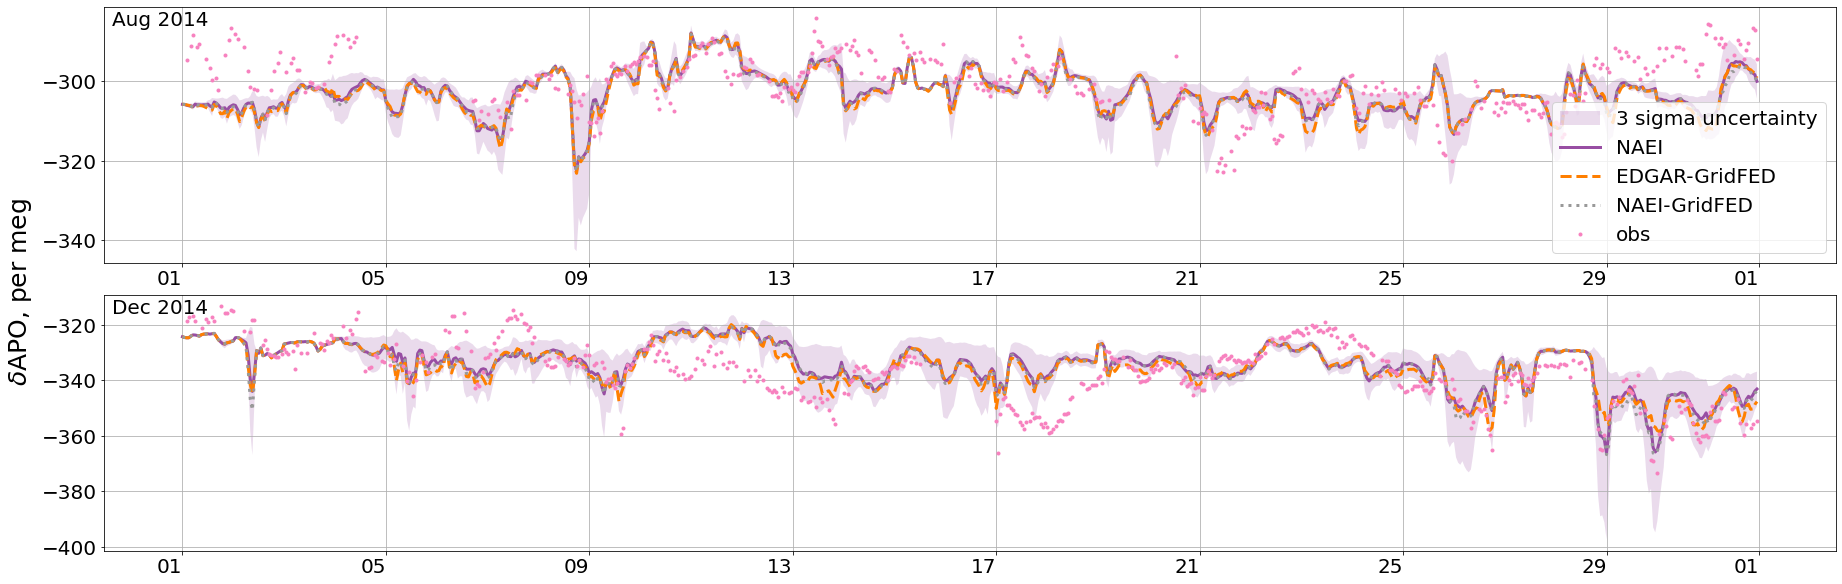

In [11]:
lines = {'ukghg': {'ls': '-', 'color': plot_info.colors['nemo']},
         'edgar': {'ls': '--', 'color': '#ff7f00'}, # '#377eb8'}, # 
         'ukghg-gridfed': {'ls': ':', 'color': '#999999'}}
        #  'ukghg-gridfed': {'ls': ':', 'color': 'dodgerblue'}}
labels = {'ukghg': 'NAEI', 'edgar': 'EDGAR-GridFED', 'ukghg-gridfed': 'NAEI-GridFED'}

fig, axes = plt.subplots(nrows=len(months), ncols=1, figsize=(25, 4*len(months)), constrained_layout=True)

for mm, (month, apo_month) in enumerate(apo_model[sites[0]].items()):
    unc_plots = axes[mm].fill_between(apo_month['ukghg'].time,
                                      apo_month['ukghg']-(sigma*apo_uncertainty_total[month]),
                                      apo_month['ukghg']+(sigma*apo_uncertainty_total[month]),
                                      facecolor=plot_info.colors['nemo'],
                                      alpha=0.2,
                                      label=f'{sigma} sigma uncertainty')
    plots = [ts.plot(ax=axes[mm], label=labels[inv], ls=lines[inv]['ls'], color=lines[inv]['color'], lw=3)
             for inv, ts in apo_month.items() if inv in lines.keys()]

obs_plots = {month: apo_month[sites[0]][0].mf.plot(ax=axes[mm], color=plot_info.colors['obs'], label='obs',
                                                   marker='o', ls='none', markersize=3)
                    if len(apo_month)>0 else None
             for mm, (month, apo_month) in enumerate(apo_obs.items())}

if len(months)>1:
       myFmt = mdates.DateFormatter('%d')
       [ax.xaxis.set_major_formatter(myFmt) for ax in axes]
       ticks = [ax.tick_params(labelsize=20, labelrotation=0) for ax in axes]
       text = [axes[mm].text(0.005, 0.985, f'{plot_info.month_names[month]} {year}', transform=axes[mm].transAxes, va='top', fontsize=20)
               for mm, month in enumerate(months)]
else:
       ticks = [ax.tick_params(labelsize=20) for ax in axes]

# ylabel = [axes[ss].set_ylabel(f'mol fraction contribution, ppm', fontsize=20) for ss, spec in enumerate(['CO2', 'O2'])]
grid = [ax.grid() for ax in axes]
ylabel = [ax.set_ylabel('') for ax in axes]
ylabel = fig.text(-0.01, 0.5, r'$\delta$APO, per meg', va='center', ha='center', rotation='vertical', fontsize=25)
xlabel = [ax.set_xlabel('') for ax in axes]
legend = axes[0].legend(loc='lower right', fontsize=20)
tick_param = [ax.tick_params(axis='both', which='major', labelsize=20) for ax in axes]

date_str = '-'.join([f'{year}{str(month).zfill(2)}' for month in months])
filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'Timeseries',
                        f'APO_Timeseries_edgarVukghg_{date_str}.png')
if save:
        print(f'Saving to {filename}')
        fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)